### 导入相关package

In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

### 定义激活函数

In [2]:
def phi(x: str):
    return (1 - np.exp(-x)) / (1 + np.exp(-x))


def phi_d(x):
    return (1 - phi(x) ** 2) / 2

In [3]:
class LearningRule:
    error_array = []
    debug = False   # debug option

    def fit_batch(self, W, X, T, eta, n_epoch):
        pass

    def fit_sequential(self, W, X, T, eta, n_epoch):
        pass

    def predict(self, W: np.ndarray, x_test: np.ndarray):
        n = x_test.shape[1]
        x_test = np.row_stack((x_test, np.ones(n)))
        prediction = np.sign(W.dot(x_test))
        prediction = prediction[0] if prediction.shape[0] == 1 else prediction
        return prediction

    def plot_learning_curve(self):
        x = np.linspace(1, len(self.error_array) + 1, num=len(self.error_array))
        plt.title("learning curve")
        plt.xlabel("epoch")
        plt.ylabel("Mean-squared error")
        plt.plot(x, self.error_array)
        plt.show()

In [4]:
class PerceptronRule(LearningRule):
    W = None

    def fit_batch(self, W, X, T, eta, n_epoch):
        factor = 1 / (np.max(T) - np.min(T))

        for epoch in range(n_epoch):
            activation = W.dot(X)
            prediction = np.sign(activation)
            error = factor * (T - prediction)
            sum_error = np.linalg.norm(error, ord=1)
            delta = eta * error.dot(X.T)
            W += delta

            self.error_array.append(sum_error)
            # print(">epoch=%s, learning rate=%s, error=%.2f" % (epoch, eta, sum_error))

            if sum_error == 0.0:
                print("\nConverged in %s epoch\n" % epoch)
                break
        print("\nTraining finished in %s epoch\n" % epoch)
        self.W = W

    def fit_sequential(self, W, X, T, eta, n_epoch):
        # n samples
        n = X.shape[1]

        # the output dimensions
        out_dim = 1 if len(T.shape) == 1 else T.shape[0]

        factor = 1 / (np.max(T) - np.min(T))

        for epoch in range(n_epoch):
            sum_error = 0.0
            for i in range(n):
                for j in range(out_dim):
                    x = X.T[i]
                    activation = W[j].dot(x.T)
                    prediction = np.sign(activation)
                    error = factor * (T[j][i] - prediction)
                    delta = eta * error * x

                    # update weights successively for each pattern
                    W[j] += delta
                    sum_error += abs(error)

                    if self.debug:
                        print("x1 = %0.3f,\t x2 = %0.3f,\t activation = %0.3f, \t predict=%s, "
                              "\t target=%s, " % (x[0], x[1], activation, prediction, T[j][i]))

            # print(">epoch=%s, learning rate=%s, error=%.2f" % (epoch, eta, sum_error))

            self.error_array.append(sum_error)
            if sum_error == 0.0:
                print("\nConverged in %s epoch\n" % epoch)
                break
        print("\nTraining finished in %s epoch\n" % epoch)
        self.W = W

In [5]:
class DeltaRule(LearningRule):
    W = None

    def fit_batch(self, W, X, T, eta, n_epoch):
        m, n = X.shape[0], X.shape[1]
        out_dim = 1 if len(T.shape) == 1 else T.shape[0]
        threshold = n * m * out_dim * 0.005
        
        for epoch in range(n_epoch):
            delta = - eta * (W.dot(X) - T).dot(X.T)
            error = np.linalg.norm(W.dot(X) - T, ord=2)
            W += delta
            # print(">epoch=%s, learning rate=%s, error=%.2f" % (epoch, eta, error))

            self.error_array.append(error)
            if error <= threshold:
                print("\nConverged in %s epoch\n" % epoch)
                break
            elif error > np.exp(10):
                raise RuntimeError("Error becomes nan")
        print("\nTraining finished in %s epoch\n" % epoch)
        self.W = W

    def fit_sequential(self, W, X, T, eta, n_epoch):
        # m features, n samples
        m, n = X.shape[0], X.shape[1]
        out_dim = 1 if len(T.shape) == 1 else T.shape[0]
        threshold = n * m * out_dim * 0.05
        
        self.error_array = []
        for e in range(n_epoch):
            sum_error = 0.0
            for t in range(n):  # iterates over each sample
                for i in range(m):  # iterates over each feature
                    for j in range(out_dim):  # iterates over each output dimension
                        x = X.T[t]  # sample: one-by-m array
                        activation = W[j].dot(x)
                        error = T[j][t] - activation
                        delta = eta * x[i] * error
                        W[j][i] += delta
                        sum_error += 0.5 * error ** 2
            self.error_array.append(sum_error)
            # print(">epoch=%s, learning rate=%s, error=%.2f" % (e, eta, sum_error))
            if sum_error < threshold:
                print("\nConverged in %s epoch\n" % e)
                break
        print("\nTraining finished in %s epoch\n" % e)
        self.W = W

In [6]:
class Perceptron:
    rule_map = {'perceptron': PerceptronRule(), 'delta': DeltaRule()}

    def __init__(self, algorithm: str = 'delta', debug: bool = False):
        # learning algorithm
        if algorithm not in self.rule_map:
            raise RuntimeError("No such algorithm: %s" % algorithm)
        self.rule = self.rule_map.get(algorithm)

        # launch mode: run or debug
        self.debug = debug

        # learned weight matrix: num(output dimensions) by num(features)
        self.W = None

        # number of output dimensions
        self.dim = None

    @staticmethod
    def init_weight(n, m):
        """
        Create an initial weight matrix filled with numbers drawn from normal distribution
        :param n:
        :param m:
        :return:
        """
        return np.random.normal(loc=0, scale=1, size=(n, m))

    def fit(self, X: np.ndarray, T: np.ndarray, eta, n_epoch: int,
            mode: str = 'sequential', plot: bool = False):
        """
        Delegate the training task to the right function
        :param X: input patterns
        :param T: learning targets
        :param n_epoch: number of max epochs
        :param mode: learn samples sequentially or in batches
        :param plot: True if need to plot the data-set, false otherwise
        :return: None
        """
        # self.epoch = n_epoch

        # the output dimensions
        self.dim = 1 if len(T.shape) == 1 else T.shape[0]

        # m features, n samples
        m, n = X.shape[0], X.shape[1]

        # add ones as the bias trick
        W = self.init_weight(self.dim, m + 1)
        X = np.row_stack((X, np.ones(n)))
        T = T.reshape(self.dim, n)

        if mode == 'batch':
            self.rule.fit_batch(W, X, T, eta, n_epoch)

        elif mode == 'sequential':
            self.rule.fit_sequential(W, X, T, eta, n_epoch)

        self.W = self.rule.W
        if plot:
            self.plot_result(X, T, self.W, eta)

    def predict(self, x_test: np.ndarray):
        return self.rule.predict(self.W, x_test)

    def getWeights(self):
        return self.W[0] if self.dim == 1 else self.W

    @staticmethod
    def plot_result(X, T, W, eta):
        n = X.shape[1]

        class_0 = np.array([X.T[i] for i in range(n) if T[0][i] == -1]).T
        class_1 = np.array([X.T[i] for i in range(n) if T[0][i] == 1]).T
        plt.title("Single layer perceptron learning, eta = %s" % eta)

        # plot the two classes
        plt.scatter(class_0[0], class_0[1], edgecolors='b', marker='o')
        plt.scatter(class_1[0], class_1[1], edgecolors='r', marker='x')

        # plot the decision boundary
        x = np.linspace(min(X[0]), max(X[0]))
        for i in range(W.shape[0]):
            y = - (W[i][0] * x + W[i][2]) / W[i][1]
            plt.plot(x, y)
        plt.show()

    def plot_learning_curve(self):
        self.rule.plot_learning_curve()


## 3.1 Classification with a single layer perceptron

### 3.1.1 Generation of linearly-separable data

In [7]:
def produce_binary(n, mean_a, mean_b, cov_a, cov_b, plot: bool = False):
    """
    Produces two sets of points from multivariate normal distribution,
    and shuffle samples to get one data set

    :param n:
        The number of samples per class
    :param plot:
        True if need to plot the data-set, false otherwise
    :return:
        A data-set that contains linearly-separable data for binary classification
    """

    np.random.seed(0)
    data_a = np.random.multivariate_normal(mean_a, cov_a, n)

    np.random.seed(1)
    data_b = np.random.multivariate_normal(mean_b, cov_b, n)

    data = np.append(data_a.T, data_b.T, axis=1)

    target_a = np.linspace(-1, -1, n)
    target_b = np.ones(n)
    target = np.append(target_a, target_b)

    # shuffle the samples
    np.random.seed(2)
    permutation = np.random.permutation(data.shape[1])

    data = data[:, permutation]
    target = target[permutation]
    
    if plot:
        plt.scatter(data_a.T[0], data_a.T[1], edgecolors='b', marker='o')
        plt.scatter(data_b.T[0], data_b.T[1], edgecolors='r', marker='x')
        plt.show()

    return data, target

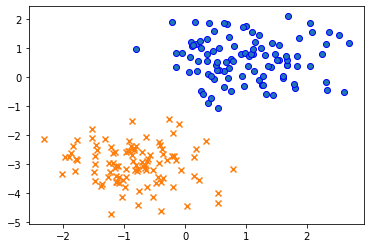

In [8]:
n = 100
mean_a = [1, 0.5]
mean_b = [-1, -3]
cov_a = [[0.5, 0], [0, 0.5]]
cov_b = cov_a
patterns, targets = produce_binary(n, mean_a, mean_b, cov_a, cov_b, plot=True)

### 3.1.2 Classification with a single-layer perceptron and analysis

In [9]:
# Apply and compare perceptron learning with the Delta learning rule in batch mode on the generated dataset. 
# Adjust the learning rate and study the convergence of the two algorithms.


Converged in 32 epoch


Training finished in 32 epoch



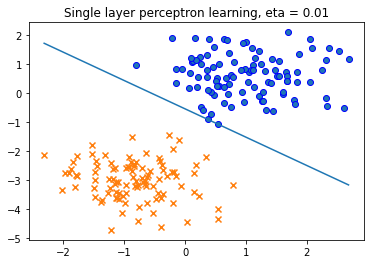


Converged in 37 epoch


Training finished in 37 epoch



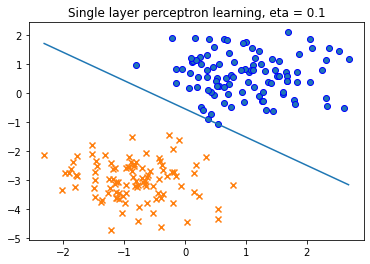


Converged in 1 epoch


Training finished in 1 epoch



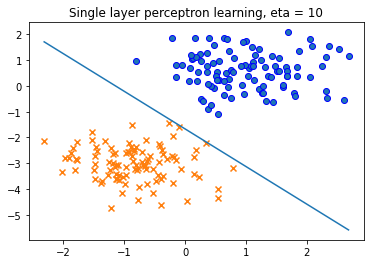

In [10]:
model = Perceptron(algorithm='perceptron')
model.fit(patterns, targets, eta=0.01, n_epoch=2000, mode='batch', plot=True)
model.fit(patterns, targets, eta=0.1, n_epoch=2000, mode='batch', plot=True)
model.fit(patterns, targets, eta=10, n_epoch=2000, mode='batch', plot=True)


Training finished in 1999 epoch



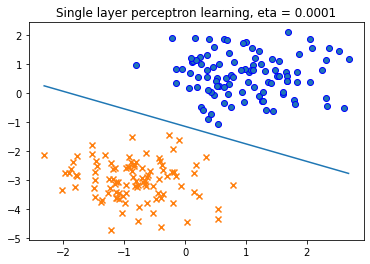


Training finished in 1999 epoch



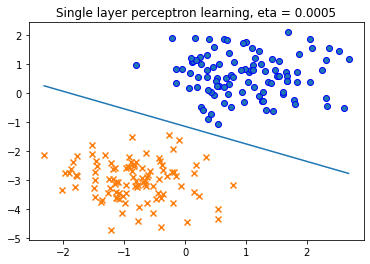


Training finished in 1999 epoch



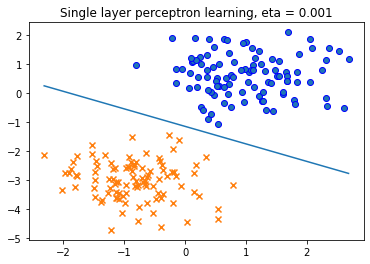

In [11]:
model = Perceptron(algorithm='delta')
model.fit(patterns, targets, eta=0.0001, n_epoch=2000, mode='batch', plot=True)
model.fit(patterns, targets, eta=0.0005, n_epoch=2000, mode='batch', plot=True)
model.fit(patterns, targets, eta=0.001, n_epoch=2000, mode='batch', plot=True)

In [12]:
# Compare sequential with a batch learning approach for the Delta rule.


Converged in 4 epoch


Training finished in 4 epoch



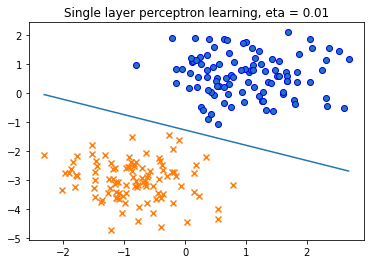

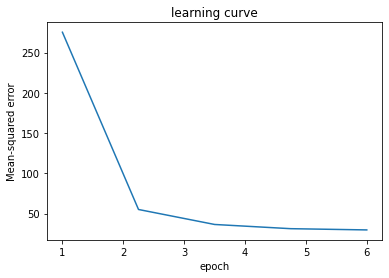

In [13]:
model = Perceptron(algorithm='delta')
model.fit(patterns, targets, eta=0.01, n_epoch=2000, mode='sequential', plot=True)
model.plot_learning_curve()


Training finished in 1999 epoch



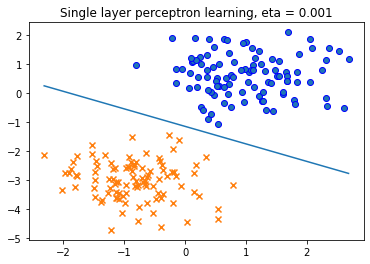

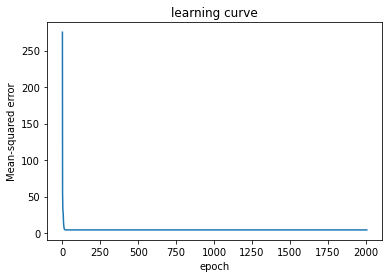

In [14]:
model.fit(patterns, targets, eta=0.001, n_epoch=2000, mode='batch', plot=True)
model.plot_learning_curve()

In [15]:
# Remove the bias, train your network with the Delta rule in batch mode and test its behaviour.

### 3.1.3 Classification of samples that are not linearly separable

In [16]:
# To this end, please generate first a dataset with such property by adjusting mA, mB, sigmaA and sigmaB.

In [17]:
n = 100
mean_a = [0, 0.5]
mean_b = [-1, -1.5]
cov_a = [[0.5, 0], [0, 0.5]]
cov_b = cov_a

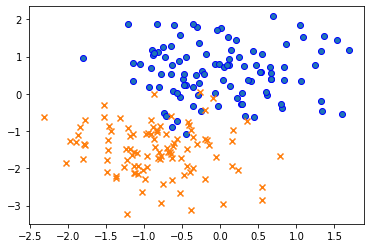

In [18]:
np.random.seed(0)
data_a = np.random.multivariate_normal(mean_a, cov_a, n)

np.random.seed(1)
data_b = np.random.multivariate_normal(mean_b, cov_b, n)

data_all = np.append(data_a.T, data_b.T, axis=1)
target_all = np.append(np.linspace(-1, -1, n), np.ones(n))

plt.scatter(data_a.T[0], data_a.T[1], edgecolors='b', marker='o')
plt.scatter(data_b.T[0], data_b.T[1], edgecolors='r', marker='x')
plt.show()

In [19]:
def sample_binary(data_a, data_b, ratio_a, ratio_b):
    n = data_a.shape[0]
    permutation = np.random.permutation(n)
    num_a = int(n * ratio_a)
    num_b = int(n * ratio_b)
    data_a = data_a[permutation[:num_a], :]
    data_b = data_b[permutation[:num_b], :]
    data = np.append(data_a.T, data_b.T, axis=1)
    target_a = np.linspace(-1, -1, num_a)
    target_b = np.ones(num_b)
    target = np.append(target_a, target_b)
    
    np.random.seed(2)
    permutation = np.random.permutation(data.shape[1])
    data = data[:, permutation]
    target = target[permutation]
    return data, target

In [20]:
# 1. random 25% from each class


Training finished in 1999 epoch



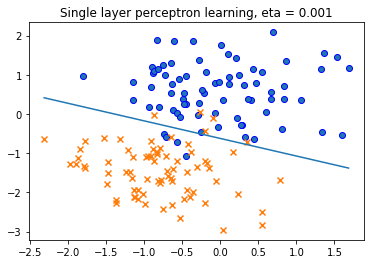

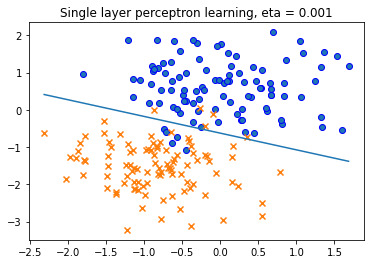

In [21]:
data, target = sample_binary(data_a, data_b, 0.75, 0.75)
model = Perceptron(algorithm='delta')
eta=0.001
model.fit(data, target, eta, n_epoch=2000, mode='batch', plot=True)
model.plot_result(data_all, target_all.reshape(1, 200), model.W, eta)

In [22]:
# 2. random 50% from class A


Training finished in 1999 epoch



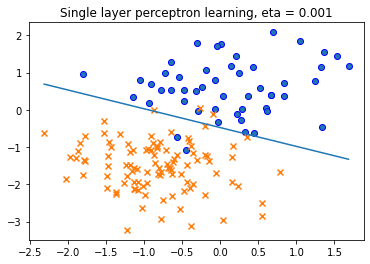

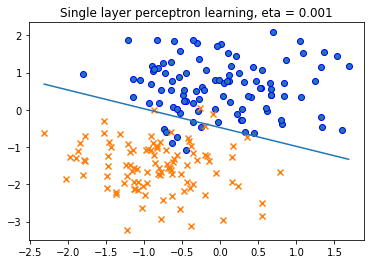

In [23]:
data, target = sample_binary(data_a, data_b, 0.5, 1)
model = Perceptron(algorithm='delta')
eta=0.001
model.fit(data, target, eta, n_epoch=2000, mode='batch', plot=True)
model.plot_result(data_all, target_all.reshape(1, 200), model.W, eta)

In [24]:
# 3. random 50% from classB


Training finished in 1999 epoch



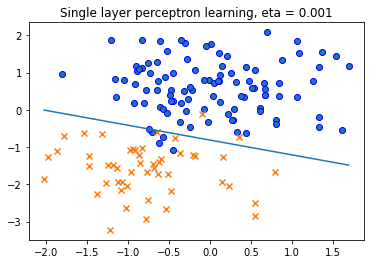

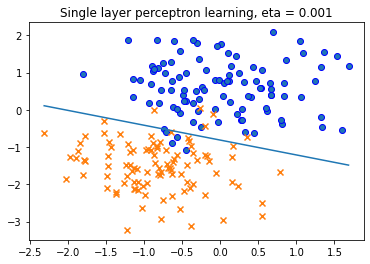

In [25]:
data, target = sample_binary(data_a, data_b, 1, 0.5)
model = Perceptron(algorithm='delta')
eta=0.001
model.fit(data, target, eta, n_epoch=2000, mode='batch', plot=True)
model.plot_result(data_all, target_all.reshape(1, 200), model.W, eta)

In [26]:
# 4. 20% from a subset of classA for which classA(1,:)<0 
# and 80% from a subset of classA for which classA(1,:)>0

In [27]:
index_1, index_2 = data_a[:,0] < 0, data_a[:, 0] >= 0
data_a_left = data_a[index_1]
data_a_right = data_a[index_2]
n1, n2 = data_a_left.shape[0], data_a_right.shape[0]
permutation = np.random.permutation(n1)
data_a_left = data_a_left[permutation[:int(n1 * 0.8)]]
data_a_right = data_a_right[permutation[:int(n2 * 0.2)]]
data_a = np.append(data_a_left, data_a_right, axis=0)
data = np.append(data_a.T, data_b.T, axis=1)
target_a = np.linspace(-1, -1, data_a.shape[0])
target_b = np.ones(data_b.shape[0])
target = np.append(target_a, target_b)


Training finished in 1999 epoch



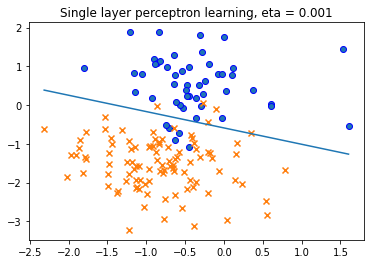

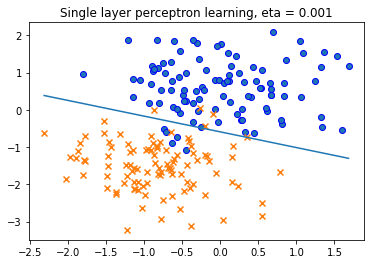

In [28]:
model = Perceptron(algorithm='delta')
eta=0.001
model.fit(data, target, eta, n_epoch=2000, mode='batch', plot=True)
model.plot_result(data_all, target_all.reshape(1, 200), model.W, eta)

## 3.2 Classification and regression with a two-layer perceptron

In [29]:
### 3.2.1 Classification of linearly non-separable data

In [30]:
# 1. Modify the number of hidden nodes and demonstrate the effect 
# the size of the hidden layer has on the performance

In [38]:
class BackPropagation(LearningRule):
    n_hidden_nodes: int
    dim = 0      # the output dimension
    alpha = 0.9  # for momentum

    def __init__(self, n_hidden_nodes):
        self.n_hidden_nodes = n_hidden_nodes
        self.n_layer = 2
        self.W = None
        self.V = None
        
    def preprocess(self, X, T):
        # m features, n samples
        m, n = X.shape[0], X.shape[1]  
        dim = 1 if len(T.shape) == 1 else T.shape[0]
        # add ones as the bias trick
        X = np.row_stack((X, np.ones(n)))
        T = T.reshape(dim, n)
        return X, T
        

    def fit_batch(self, X, T, eta, n_epoch):
        X, T = self.preprocess(X, T)
        # M features, N samples
        M, N = X.shape[0], X.shape[1]
        dim = 1 if len(T.shape) == 1 else T.shape[0]
        
        W = np.random.normal(loc=0, scale=1, size=(self.n_hidden_nodes, M))
        V = np.random.normal(loc=0, scale=1, size=(dim, self.n_hidden_nodes + 1))

        alpha = self.alpha
        d_W = np.zeros(W.shape)
        d_V = np.zeros(V.shape)
        threshold = 0.001
        for epoch in range(n_epoch):
            # forward pass
            H_in = W.dot(X)
            H_out = np.row_stack((phi(H_in), np.ones(N)))

            O_in = V.dot(H_out)
            O_out = phi(O_in)

            # backward pass
            delta_o = np.multiply(O_out - T, phi_d(O_in))
            delta_h = np.multiply(V.T.dot(delta_o)[1:self.n_hidden_nodes + 1, :], phi_d(H_in))

            # weight update
            d_W = alpha * d_W - (1 - alpha) * (delta_h.dot(X.T))
            d_V = alpha * d_V - (1 - alpha) * (delta_o.dot(H_out.T))

            W += eta * d_W
            V += eta * d_V

            sum_error = 0.5 * np.linalg.norm((T - O_out), ord=2)
            self.error_array.append(sum_error)

            # print(">epoch=%s, learning rate=%s, error=%.2f" % (epoch, eta, sum_error))
            if sum_error < threshold:
                print("\nConverged in %s epoch\n" % e)
                break
        print("\nTraining finished in %s epoch\n" % epoch)
        self.W = W
        self.V = V
        self.dim = dim

    def fit_sequential(self, W, X, T, eta, n_epoch):
        # M features, N samples
        M, N = X.shape[0], X.shape[1]
        dim = 1 if len(T.shape) == 1 else T.shape[0]

        W = np.random.normal(loc=0, scale=1, size=(self.n_hidden_nodes, M))
        V = np.random.normal(loc=0, scale=1, size=(dim, self.n_hidden_nodes + 1))
        H_in = np.zeros((self.n_hidden_nodes, 1))
        H_out = np.zeros((self.n_hidden_nodes + 1, 1))
        delta_h = np.zeros(H_out.shape)

        O_out = np.zeros((dim, 1))
        O_in = np.zeros(O_out.shape)
        delta_o = np.zeros(O_out.shape)

        d_W = 0.0
        d_V = 0.0
        alpha = self.alpha
        threshold = N * M * dim * 0.001
        for epoch in range(n_epoch):
            sum_error = 0.0
            for n in range(N):  # iterates over each sample
                # forward pass
                x = X.T[n]
                t = T[:, n]
                for k in range(self.n_hidden_nodes):
                    w = W[k]
                    H_in[k] = w.dot(x)
                    H_out[k] = phi(w.dot(x))
                H_out[-1][0] = 1
                for k in range(dim):
                    v = V[k]
                    O_in[k] = v.dot(H_out)
                    O_out[k] = phi(v.dot(H_out))
                    sum_error += 0.5 * (t[k] - O_out[k]) ** 2

                # backward pass
                for k in range(dim):
                    delta_o[k] = (O_out[k] - t[k]) * phi_d(O_in[k])

                for j in range(self.n_hidden_nodes):
                    delta_h[j] = (delta_o.dot(V[:, j])) * phi_d(H_in[j])

                # weight update
                for j in range(W.shape[0]):
                    for i in range(W.shape[1]):
                        d_W = alpha * d_W - (1 - alpha) * (x[i] * delta_h[j])
                        W[j][i] += eta * d_W

                for k in range(V.shape[0]):
                    for j in range(V.shape[1]):
                        d_V = alpha * d_V - (1 - alpha) * (H_out[j] * delta_o[k])
                        V[k][j] += eta * d_V

            self.error_array.append(sum_error)

            # print(">epoch=%s, learning rate=%s, error=%.2f" % (epoch, eta, sum_error))
            if sum_error < threshold:
                print("\nConverged in %s epoch\n" % e) 
                break
        print("\nTraining finished in %s epoch\n" % epoch)
        self.W = W
        self.V = V
        self.dim = dim

    def predict(self, X: np.ndarray):
        W, V = self.W, self.V
        X = np.row_stack((X, np.ones(X.shape[1])))
        H = phi(W.dot(X))
        H = np.row_stack((H, np.ones(H.shape[1])))
        Output = phi(V.dot(H))
        prediction = np.sign(Output)
        return prediction[0] if prediction.shape[0] == 1 else prediction


In [39]:
model = BackPropagation(n_hidden_nodes=10)
eta=0.001
model.fit_batch(data_all, target_all, eta, n_epoch=2000)



Training finished in 1999 epoch

